In [1]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import openpyxl

In [2]:
output_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output')
risk_path = os.path.join(output_path,'risk')
figure_path = os.path.join('C:\\','projects','pg_risk_analysis','figures')

# Read and restructure results

In [140]:
def restructure_output(hazard_type,infra_type):
    """
    Read the risk results of historical (FL) and present (TC) climate model
    """
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    
    # country_codes does not include SGP (no fl/tc risk)
    if hazard_type == 'fl':
        country_codes = ['CHN','IDN','JPN','KOR','MMR','MYS','PHL','PRK','THA','TWN','VNM']
    elif hazard_type == 'tc':
        country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','THA','TWN','VNM']
        
    reframe_risk = {}
    model_risk = {}
    
    if hazard_type == 'fl':
        climate_model = 'historical'
    elif hazard_type == 'tc':
        climate_model = 'present'
        
    for country_code in country_codes:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]

        model_risk[country_code] = reframe_risk[country_code][climate_model].reset_index()
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = climate_model
        model_risk[country_code]['infra_type'] = infra_type

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])

        risk_result['asset_type'] = risk_result['asset_type'].replace({'line_risk':'line','plant_risk':'plant',
                                                                       'substation_risk': 'substation','tower_risk':'tower',
                                                                       'pole_risk': 'pole'})
        
        risk_result['country_code'] = risk_result['country_code'].replace({'BRN':'Brunei','CHN':'China','IDN':'Indonesia','JPN':'Japan',
                                                                           'LAO':'Laos','MYS':'Malaysia','MNG':'Mongolia','MMR':'Myanmar',
                                                                           'PRK':'North Korea','PHL':'Philippines','KHM':'Cambodia',
                                                                           'SGP':'Singapore','KOR':'South Korea','TWN':'Taiwan',
                                                                           'THA':'Thailand','VNM':'Vietnam'})
        
        risk_result['infra_type'] = risk_result['infra_type'].replace({'osm':'Open\nStreet Map','gov':'Government\ndata'})

    return risk_result

In [44]:
df = restructure_output('fl','osm')

# Create figure for TC OSM present risk

In [158]:
tc_osm_risk = restructure_output('tc','osm')#.loc[country_code]
tc_gov_risk = restructure_output('tc','gov')#.loc[country_code]
tc_risk = pd.concat([tc_osm_risk,tc_gov_risk], axis=0)

In [159]:
tc_risk.loc['BRN']

,curve_code,asset_type,mean_risk,lower_risk,upper_risk,country_code,climate_model,infra_type
0,W2_1_1,substation,329355.087823,247016.315867,411693.859778,Brunei,present,Open\nStreet Map
1,W2_1_2,substation,203468.254255,152601.190691,254335.317819,Brunei,present,Open\nStreet Map
2,W2_1_3,substation,109785.029274,82338.771956,137231.286593,Brunei,present,Open\nStreet Map
3,W2_1_4,substation,69164.568443,51873.426332,86455.710553,Brunei,present,Open\nStreet Map
4,W2_1_5,substation,58186.065515,43639.549136,72732.581894,Brunei,present,Open\nStreet Map
...,...,...,...,...,...,...,...,...
121,W2_7_2,substation,139177.219049,104382.914287,173971.523811,Brunei,present,Government\ndata
122,W2_7_3,substation,75095.621789,56321.716342,93869.527236,Brunei,present,Government\ndata
123,W2_7_4,substation,47310.241727,35482.681295,59137.802159,Brunei,present,Government\ndata
124,W2_7_5,substation,39800.679548,29850.509661,49750.849435,Brunei,present,Government\ndata


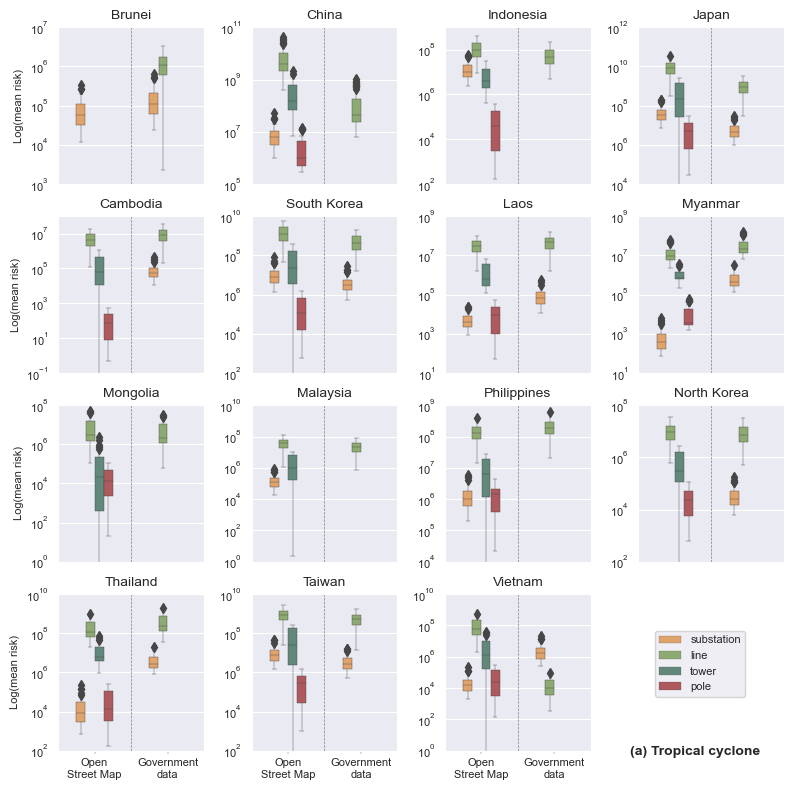

In [197]:
country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','THA','TWN','VNM']

fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=True, sharey=False)

# Palette: 1 or 3 !!!!!!!!!!!
my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
my_pal3 = {"line": "#264653", "plant": "#FE7F2D", "substation": "#FCCA46", "tower": "#A1C181", "pole": "#619B8A"}
my_pal4 = {"line": "#264653", "plant": "#2A9D8F", "substation": "#E9C46A", "tower": "#F4A261", "pole": "#E76F51"}

for i, country_code in enumerate(country_codes):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    # tc_osm_risk = restructure_output('tc','osm').loc[country_code]
    # tc_gov_risk = restructure_output('tc','gov').loc[country_code]
    tc_country_risk = tc_risk.loc[country_code]
    
    sns.set_style('darkgrid')

    sns.boxplot(data=tc_country_risk, x='infra_type', y='mean_risk', hue='asset_type',width=0.5,linewidth=0.3, palette=my_pal1, ax=ax)

    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_title(tc_country_risk['country_code'].values[0], fontsize=10)
    ax.tick_params(labelsize=8)
    # ax.set_ylim(None)
    
    # Remove legends
    ax.get_legend().remove()
    
    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(mean risk)', fontsize=8)
    else:
        ax.set_ylabel('')

    if row == 3:
        # ax.set_xlabel('Infrastructure type', fontsize=10, color='black', position=(0.5, -0.9))
        ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')

    # Add a vertical line in the middle of each subplot
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.5)
        
# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()

plt.tight_layout()
#plt.subplots_adjust(left=0.1,right=0,bottom=0,top=0,wspace=0.3,hspace=0.4)

brn_ax = axes.flatten()[0]
chn_ax = axes.flatten()[1]
idn_ax = axes.flatten()[2]
jpn_ax = axes.flatten()[3]
khm_ax = axes.flatten()[4]
kor_ax = axes.flatten()[5]
lao_ax = axes.flatten()[6]
mmr_ax = axes.flatten()[7]
mng_ax = axes.flatten()[8]
mys_ax = axes.flatten()[9]
phl_ax = axes.flatten()[10]
prk_ax = axes.flatten()[11]
tha_ax = axes.flatten()[12]
twn_ax = axes.flatten()[13]
vnm_ax = axes.flatten()[14]

brn_ax.set_ylim([1e3,1e7])
chn_ax.set_ylim([1e5,1e11])

idn_ax.set_ylim([1e2,1e9])

jpn_ax.set_ylim([1e4,1e12])

khm_ax.set_ylim([1e-1,1e8])
kor_ax.set_ylim([1e2,1e10])
lao_ax.set_ylim([1e1,1e9])

mmr_ax.set_ylim([1e1,1e9])
mng_ax.set_ylim([1e0,1e8])

mys_ax.set_ylim([1e0,1e10])

phl_ax.set_ylim([1e4,1e9])

prk_ax.set_ylim([1e2,1e8])

tha_ax.set_ylim([1e2,1e10])
twn_ax.set_ylim([1e2,1e10])
vnm_ax.set_ylim([1e0,1e10])
        
# Adjust the coordinates of legend as needed                                                                                            
legend_position = (1.4, 0.8)
plt.legend(bbox_to_anchor=legend_position,fontsize=8)

fig.text(0.87, 0.05, "(a) Tropical cyclone", fontsize=10, ha='center',fontweight='bold')

plt.savefig(os.path.join(figure_path,'Figure 5-a OSM & GOV.jpg'),dpi=450)

plt.show()


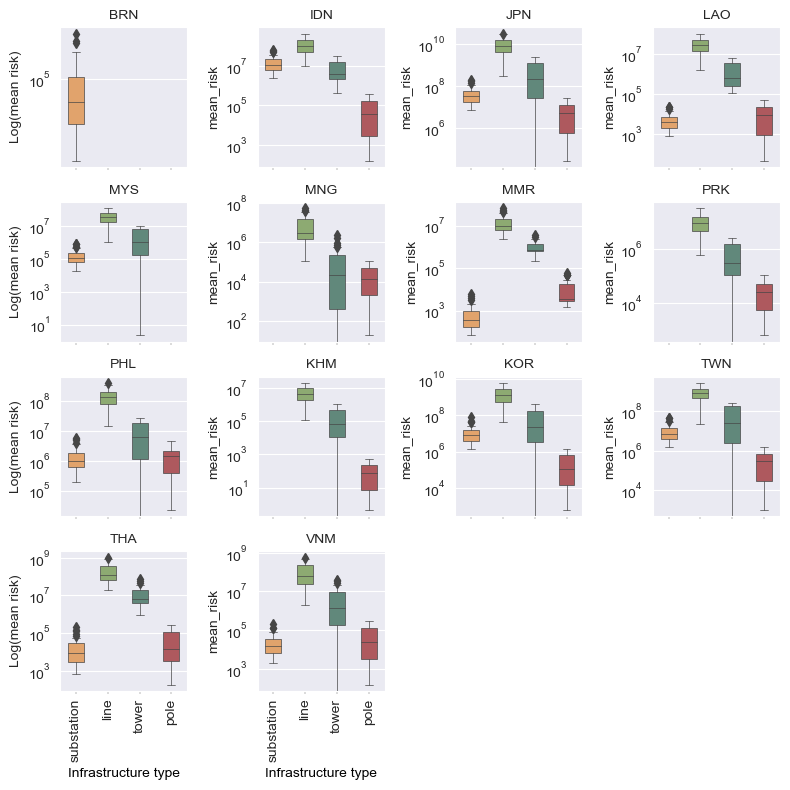

In [327]:
country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','THA','TWN','VNM']

fig, axes = plt.subplots(4,4, figsize=(8,8), sharex=True, sharey=False)

# Palette: 1 or 3 !!!!!!!!!!!
my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
# my_pal2 = {"line": "#540D6E", "plant": "#EE4266", "substation": "#FFD23F", "tower": "#3BCEAC", "pole": "#0EAD69"}
my_pal3 = {"line": "#264653", "plant": "#FE7F2D", "substation": "#FCCA46", "tower": "#A1C181", "pole": "#619B8A"}
my_pal4 = {"line": "#264653", "plant": "#2A9D8F", "substation": "#E9C46A", "tower": "#F4A261", "pole": "#E76F51"}

for i, country_code in enumerate(country_codes):
    row = i // 4
    col = i % 4
    ax = axes[row][col]
    
    tc_osm_risk = restructure_output('tc','osm').loc[country_code]
    
    sns.set_style('darkgrid')

    sns.boxplot(data=tc_osm_risk, x='asset_type', y='mean_risk',width=0.5,linewidth=0.5, whis=1.5, palette=my_pal1, ax=ax)
    
    ax.set_yscale('log')
    ax.set_title(country_code,fontsize=10)
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')

    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(mean risk)',fontsize=10)

    if row == 3:
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        ax.set_xlabel('Infrastructure type', fontsize=10, color='black', position=(0.5, -0.9))

# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()
    
plt.tight_layout()
plt.savefig(os.path.join(figure_path,'tc_osm_risk_1.jpg'),dpi=600)

plt.show()

# Create figure for FL historical risk

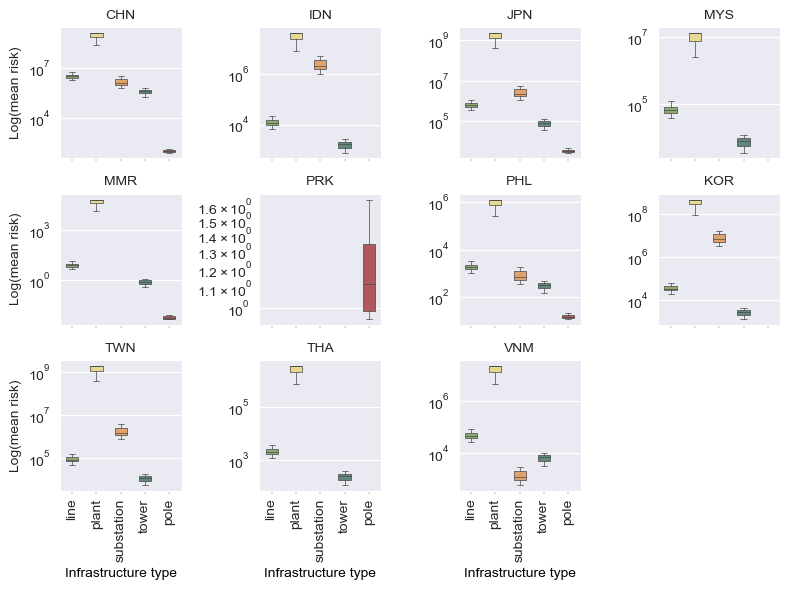

In [43]:
country_codes = ['CHN','IDN','JPN','KOR','MMR','MYS','PHL','PRK','THA','TWN','VNM'] #ALL countries with fl risk

fig, axes = plt.subplots(3,4, figsize=(8,6), sharex=True, sharey=False)

# Palette: 1 or 3 !!!!!!!!!!!
my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
# my_pal2 = {"line": "#540D6E", "plant": "#EE4266", "substation": "#FFD23F", "tower": "#3BCEAC", "pole": "#0EAD69"}
my_pal3 = {"line": "#264653", "plant": "#FE7F2D", "substation": "#FCCA46", "tower": "#A1C181", "pole": "#619B8A"}
my_pal4 = {"line": "#264653", "plant": "#2A9D8F", "substation": "#E9C46A", "tower": "#F4A261", "pole": "#E76F51"}

for i, country_code in enumerate(country_codes):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    fl_osm_risk = restructure_output('fl','osm').loc[country_code]
    # fl_osm_risk['asset_type'] = fl_osm_risk['asset_type'].replace({'line_risk':'line','plant_risk':'plant',
    #                                                                'substation_risk': 'substation','tower_risk':'tower','pole_risk': 'pole'})
    
    sns.set_style('darkgrid')

    sns.boxplot(data=fl_osm_risk, x='asset_type', y='mean_risk',width=0.5,linewidth=0.5, palette=my_pal1, ax=ax)

    ax.set_yscale('log')
    ax.set_title(country_code, fontsize=10)
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')
    
    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(mean risk)', fontsize=10)
    else:
        ax.set_ylabel('')
    
    # if row == 2:
    #     for tick in ax.get_xticklabels():
    #         tick.set_rotation(90)
    #     ax.set_xlabel('Infrastructure type', fontsize=10, color='black', position=(0.5, -0.9))
        
    # if row == 1 and col == 3:
    #     for tick in ax.get_xticklabels():
    #         tick.set_rotation(90)
    #     ax.set_xlabel('Infrastructure type', fontsize=10, color='black', position=(0.5, -0.9))

    # Remove legends
    #ax.get_legend().remove()

# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()

plt.tight_layout()

plt.savefig(os.path.join(figure_path,'Figure 5-b.jpg'),dpi=450)

plt.show()

In [156]:
fl_osm_risk = restructure_output('fl','osm')#.loc[country_code]
fl_gov_risk = restructure_output('fl','gov')#.loc[country_code]
fl_risk = pd.concat([fl_osm_risk,fl_gov_risk], axis=0)

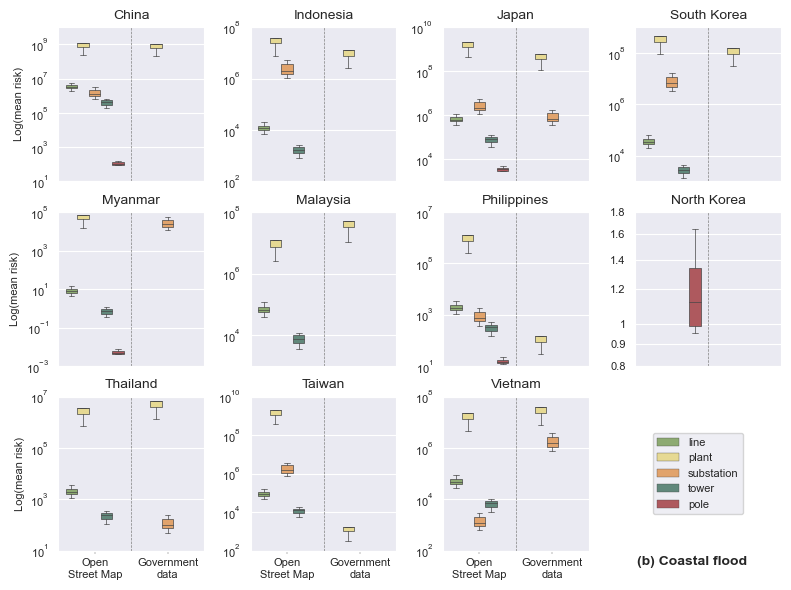

In [193]:
country_codes = ['CHN','IDN','JPN','KOR','MMR','MYS','PHL','PRK','THA','TWN','VNM']

fig, axes = plt.subplots(3, 4, figsize=(8,6), sharex=True, sharey=False)

# Palette: 1 or 3 !!!!!!!!!!!
my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
my_pal3 = {"line": "#264653", "plant": "#FE7F2D", "substation": "#FCCA46", "tower": "#A1C181", "pole": "#619B8A"}
my_pal4 = {"line": "#264653", "plant": "#2A9D8F", "substation": "#E9C46A", "tower": "#F4A261", "pole": "#E76F51"}

for i, country_code in enumerate(country_codes):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    fl_country_risk = fl_risk.loc[country_code]
    #print(type(fl_risk['country_code']))
    
    sns.set_style('darkgrid')

    sns.boxplot(data=fl_country_risk, x='infra_type', y='mean_risk', hue='asset_type',width=0.8,linewidth=0.5, palette=my_pal1, ax=ax)

    ax.set_xlabel('')

    ax.set_yscale('log')
    ax.set_title(fl_country_risk['country_code'].values[0], fontsize=10)
    ax.tick_params(labelsize=8)
    
    # Remove legends
    ax.get_legend().remove()

    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(mean risk)', fontsize=8)
    else:
        ax.set_ylabel('')

    if row == 2:
        # ax.set_xlabel('Infrastructure type', fontsize=10, color='black', position=(0.5, -0.9))
        ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')

    # Add a vertical line in the middle of each subplot
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.5)
        
# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.32, hspace=0.2)

chn_ax = axes.flatten()[0]
idn_ax = axes.flatten()[1]
jpn_ax = axes.flatten()[2]
kor_ax = axes.flatten()[3]
mmr_ax = axes.flatten()[4]
mys_ax = axes.flatten()[5]
phl_ax = axes.flatten()[6]
prk_ax = axes.flatten()[7]
tha_ax = axes.flatten()[8]
twn_ax = axes.flatten()[9]
vnm_ax = axes.flatten()[10]

chn_ax.set_ylim([1e1,1e10])
# chn_ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1e1))

idn_ax.set_ylim([1e2,1e8])

jpn_ax.set_ylim([1e3,1e10])
# jpn_ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1e1))

kor_ax.set_ylim([1e3,1e9])

mmr_ax.set_ylim([1e-3,1e5])

mys_ax.set_ylim([1e3,1e8])
# chn_ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1e1))

phl_ax.set_ylim([1e1,1e7])

#prk_ax.set_ylim([0.8,1.8])
prk_ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:g}"))
prk_ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2))
prk_ax.set_yticks([0.8,0.9,1.0,1.2,1.4,1.6,1.8])

tha_ax.set_ylim([1e1,1e7])
twn_ax.set_ylim([1e2,1e10])
vnm_ax.set_ylim([1e2,1e8])
        
# Adjust the coordinates of legend as needed                                                                                            
legend_position = (1.4, 0.8)
plt.legend(bbox_to_anchor=legend_position,fontsize=8)

fig.text(0.87, 0.05, "(b) Coastal flood", fontsize=10, ha='center',fontweight='bold')

plt.savefig(os.path.join(figure_path,'Figure 5-b OSM & GOV.jpg'),dpi=450)

plt.show()


## ONLY FOR BACKUP

In [ ]:
# Reframe FL OSM risk outputs
def restructure_output(hazard_type,infra_type):
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    df.to_csv(os.path.join(output_path,'{}_risk.csv'.format(hazard_type)))

    return df

re_output = restructure_output('fl','osm')
country_codes = ['BRN','CHN','IDN','JPN','LAO','MYS','MNG','MMR','PRK','PHL','SGP','KHM','KOR','TWN','THA','VNM']
risk_result = {}
risk_hist = {}
risk_rcp = {}

for country_code in country_codes:
    
    risk_result[country_code] = re_output.unstack(level=-1).T.unstack(level=-1)[country_code]

    risk_hist[country_code] = risk_result[country_code]['historical'].reset_index()
    # print(risk_hist[country_code])
    
    risk_hist[country_code]['country_code'] = country_code
    risk_hist[country_code]['climate_model'] = 'historical'
    risk_hist[country_code]['infra_type'] = 'osm'
    risk_hist[country_code] = risk_hist[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
    risk_rcp[country_code] = risk_result[country_code]['rcp8p5'].reset_index()
    risk_rcp[country_code]['country_code'] = country_code
    risk_rcp[country_code]['climate_model'] = 'rcp8p5'
    risk_rcp[country_code]['infra_type'] = 'osm'
    risk_rcp[country_code] = risk_rcp[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
df_risk_hist = pd.concat(risk_hist.values(), keys=risk_hist.keys())
df_risk_rcp = pd.concat(risk_rcp.values(), keys=risk_rcp.keys())
fl_risk = pd.concat([df_risk_hist, df_risk_rcp])
fl_risk

In [55]:
# Reframe TC OSM risk outputs
def restructure_output(hazard_type,infra_type):
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    df.to_csv(os.path.join(output_path,'{}_risk.csv'.format(hazard_type)))

    return df

re_output = restructure_output('tc','osm')
# print(tc_osm_output)
country_codes = ['BRN','IDN','JPN','LAO','MYS','MNG','MMR','PRK','PHL','KHM','KOR','TWN','THA','VNM'] #ADD CHN!!!!!!!!
#country_codes = ['BRN','LAO','MNG','MMR','PRK','PHL','KHM','KOR','TWN','THA','VNM'] #ADD CHINA, JAPAN, INDONESIA< MALAYSIA,SINGAPORE!!!!!
climate_models = ['present','CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']

risk_result = {}
risk_cmcc = {}
risk_cnrm = {}
risk_ec = {}
risk_had = {}
risk_pres = {}

for country_code in country_codes:
    
    risk_result[country_code] = re_output.unstack(level=-1).T.unstack(level=-1)[country_code]

    risk_cmcc[country_code] = risk_result[country_code]['CMCC-CM2-VHR4'].reset_index()
    risk_cmcc[country_code]['country_code'] = country_code
    risk_cmcc[country_code]['climate_model'] = 'CMCC-CM2-VHR4'
    risk_cmcc[country_code]['infra_type'] = 'osm'
    risk_cmcc[country_code] = risk_cmcc[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
    risk_cnrm[country_code] = risk_result[country_code]['CNRM-CM6-1-HR'].reset_index()
    risk_cnrm[country_code]['country_code'] = country_code
    risk_cnrm[country_code]['climate_model'] = 'CNRM-CM6-1-HR'
    risk_cnrm[country_code]['infra_type'] = 'osm'
    risk_cnrm[country_code] = risk_cnrm[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
    risk_ec[country_code] = risk_result[country_code]['EC-Earth3P-HR'].reset_index()
    risk_ec[country_code]['country_code'] = country_code
    risk_ec[country_code]['climate_model'] = 'EC-Earth3P-HR'
    risk_ec[country_code]['infra_type'] = 'osm'
    risk_ec[country_code] = risk_ec[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
    risk_had[country_code] = risk_result[country_code]['HadGEM3-GC31-HM'].reset_index()
    risk_had[country_code]['country_code'] = country_code
    risk_had[country_code]['climate_model'] = 'HadGEM3-GC31-HM'
    risk_had[country_code]['infra_type'] = 'osm'
    risk_had[country_code] = risk_had[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
    risk_pres[country_code] = risk_result[country_code]['present'].reset_index()
    risk_pres[country_code]['country_code'] = country_code
    risk_pres[country_code]['climate_model'] = 'present'
    risk_pres[country_code]['infra_type'] = 'osm'
    risk_pres[country_code] = risk_pres[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
    
df_risk_cmcc = pd.concat(risk_cmcc.values(), keys=risk_cmcc.keys())
df_risk_cnrm = pd.concat(risk_cnrm.values(), keys=risk_cnrm.keys())
df_risk_ec = pd.concat(risk_ec.values(), keys=risk_ec.keys())
df_risk_had = pd.concat(risk_had.values(), keys=risk_had.keys())
df_risk_pres = pd.concat(risk_pres.values(), keys=risk_pres.keys())

tc_risk = pd.concat([df_risk_cmcc, df_risk_cnrm, df_risk_ec, df_risk_had, df_risk_pres])
tc_risk

curve_code       asset_type      mean_risk     lower_risk   
BRN 0       W2_1_1  substation_risk  306119.530398  229589.647799  \
    1       W2_1_2  substation_risk  189113.843224  141835.382418   
    2       W2_1_3  substation_risk  102039.843466   76529.882600   
    3       W2_1_4  substation_risk   64285.101384   48213.826038   
    4       W2_1_5  substation_risk   54081.117037   40560.837778   
...            ...              ...            ...            ...   
VNM 205      W4_52        pole_risk  296418.899046  222314.174284   
    206      W4_53        pole_risk  295111.768537  221333.826402   
    207      W4_54        pole_risk  295602.365005  221701.773754   
    208      W4_55        pole_risk  296267.818266  222200.863700   
    209      W4_56        pole_risk    2121.532542    1591.149407   

            upper_risk country_code  climate_model infra_type  
BRN 0    382649.412998          BRN  CMCC-CM2-VHR4        osm  
    1    236392.304030          BRN  CMCC-CM2-VHR4        osm  
    2    127549.804333          BRN  CMCC-CM2-VHR4        osm  
    3     80356.376730          BRN  CMCC-CM2-VHR4        osm  
    4     67601.396296          BRN  CMCC-CM2-VHR4        osm  
...                ...          ...            ...        ...  
VNM 205  370523.623807          VNM        present        osm  
    206  368889.710671          VNM        present        osm  
    207  369502.956256          VNM        present        osm  
    208  370334.772833          VNM        present        osm  
    209    2651.915678          VNM        present        osm  

[15750 rows x 8 columns]

In [122]:
data = fl_risk[(fl_risk['country_code']=='BRN') & (fl_risk['climate_model']=='historical')]
data

0      curve_code       asset_type  mean_risk  lower_risk  upper_risk   
BRN 0      F5_1_1        line_risk        NaN         NaN         NaN  \
    1      F5_1_2        line_risk        NaN         NaN         NaN   
    2      F5_1_3        line_risk        NaN         NaN         NaN   
    3      F5_1_4        line_risk        NaN         NaN         NaN   
    4      F5_1_5        line_risk        NaN         NaN         NaN   
    5      F5_1_6        line_risk        NaN         NaN         NaN   
    6      F5_1_7        line_risk        NaN         NaN         NaN   
    7      F5_1_8        line_risk        NaN         NaN         NaN   
    8      F5_1_9        line_risk        NaN         NaN         NaN   
    9     F5_1_10        line_risk        NaN         NaN         NaN   
    10    F5_1_11        line_risk        NaN         NaN         NaN   
    11    F5_1_12        line_risk        NaN         NaN         NaN   
    12     F1_1_1       plant_risk        NaN         NaN         NaN   
    13     F1_1_2       plant_risk        NaN         NaN         NaN   
    14     F1_1_3       plant_risk        NaN         NaN         NaN   
    15     F2_1_1  substation_risk        NaN         NaN         NaN   
    16     F2_1_2  substation_risk        NaN         NaN         NaN   
    17     F2_1_3  substation_risk        NaN         NaN         NaN   
    18     F3_1_1       tower_risk        NaN         NaN         NaN   
    19     F3_1_2       tower_risk        NaN         NaN         NaN   
    20     F4_1_1        pole_risk        NaN         NaN         NaN   
    21     F4_1_2        pole_risk        NaN         NaN         NaN   
    22     F4_1_3        pole_risk        NaN         NaN         NaN   
    23     F4_1_4        pole_risk        NaN         NaN         NaN   

0      country_code climate_model infra_type  
BRN 0           BRN    historical        osm  
    1           BRN    historical        osm  
    2           BRN    historical        osm  
    3           BRN    historical        osm  
    4           BRN    historical        osm  
    5           BRN    historical        osm  
    6           BRN    historical        osm  
    7           BRN    historical        osm  
    8           BRN    historical        osm  
    9           BRN    historical        osm  
    10          BRN    historical        osm  
    11          BRN    historical        osm  
    12          BRN    historical        osm  
    13          BRN    historical        osm  
    14          BRN    historical        osm  
    15          BRN    historical        osm  
    16          BRN    historical        osm  
    17          BRN    historical        osm  
    18          BRN    historical        osm  
    19          BRN    historical        osm  
    20          BRN    historical        osm  
    21          BRN    historical        osm  
    22          BRN    historical        osm  
    23          BRN    historical        osm

# Fix errors of IDN and MYS

In [21]:
collect_point_damages = [[['1_1', 40720, 'W3_1', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_2', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_3', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_4', 19.23087407890287, 14.423155559177149, 24.038592598628586], ['1_1', 40720, 'W3_5', 2.9634781067561807e-295, 2.222608580067135e-295, 3.704347633445226e-295], ['1_1', 40720, 'W3_6', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_7', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_8', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_9', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_10', 0.0, 0.0, 0.0], ['1_1', 40720, 'W3_11', 670.7246970035628, 503.04352275267206, 838.4058712544536], ['1_1', 40720, 'W3_12', 1542.8778598254974, 1157.1583948691227, 1928.5973247818715], ['1_1', 40720, 'W3_13', 1563.6550458229294, 1172.7412843671968, 1954.5688072786618]]]

In [22]:
results = pd.DataFrame([item for sublist in collect_point_damages
                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])

In [94]:
import pickle
# collect_point_damages.to_pickle('collect_point_damages')
with open(os.path.join(output_path,'collect_point_damages.pkl'), 'wb') as f:
    pickle.dump(collect_point_damages,f)

In [15]:
with open(os.path.join(output_path,'collect_point_damages.pkl'), 'rb') as f:
    collect_point_damages = pickle.load(f)
    # print(collect_point_damages[0:2])
    # print(type(collect_point_damages[0:1]))

In [14]:
type(collect_point_damages)

list

In [8]:
def has_int(lst):
    has_integer = False
    
    for sublist in lst:
        # print(sublist)
        for item in sublist:
            # print(item)
            if isinstance(item, int):
                print(item)
                has_integer = True
                break

        if has_integer:
            break

    if has_integer:
        return print("The list contains at least one integer.")
    else:
        return print("The list does not contain any integers.")

has_int(collect_point_damages)

print(len(collect_point_damages))

total_items = 0

for sublist in collect_point_damages:
    total_items += len(sublist)
print(total_items)

39473
The list contains at least one integer.
100890
2824700


In [9]:
modified_list = [[item for item in sublist if not isinstance(item, int)] for sublist in collect_point_damages]
has_int(modified_list)
print(len(modified_list))

total_items_modified = 0
for sublist in modified_list:
    total_items_modified += len(sublist)
print(total_items_modified)

The list does not contain any integers.
100890
2824660


In [45]:
results = pd.DataFrame([item for sublist in modified_list
                        for item in sublist],columns=['rp','asset','curve','meandam','lowerdam','upperdam'])
results.asset

0             94
1             94
2             94
3             94
4             94
           ...  
2824655    40720
2824656    40720
2824657    40720
2824658    40720
2824659    40720
Name: asset, Length: 2824660, dtype: object

In [50]:
results.keys()
results.head(10)

,rp,asset,curve,meandam,lowerdam,upperdam
0,1_1,94,W3_1,0.0,0.0,0.0
1,1_1,94,W3_2,0.0,0.0,0.0
2,1_1,94,W3_3,0.0,0.0,0.0
3,1_1,94,W3_4,0.0,0.0,0.0
4,1_1,94,W3_5,0.0,0.0,0.0
5,1_1,94,W3_6,0.0,0.0,0.0
6,1_1,94,W3_7,0.0,0.0,0.0
7,1_1,94,W3_8,0.0,0.0,0.0
8,1_1,94,W3_9,0.0,0.0,0.0
9,1_1,94,W3_10,0.0,0.0,0.0


In [14]:
if '_' in results.columns:
    print("'_'' is present as a column in 'results_asset' DataFrame.")
else:
    print("'_'' is not present as a column in 'results_asset' DataFrame.")


'_'' is not present as a column in 'results_asset' DataFrame.


In [51]:
print(results['asset'].value_counts())
results.drop(results.index[(results.iloc[:, 1] == '_')], inplace=True)
results.drop(results.index[(results.iloc[:, 1] == '3')], inplace=True)

results['asset'].value_counts()
results
#.astype(int)

asset
94       280
30952    280
30945    280
30946    280
30947    280
        ... 
15854    280
15855    280
15856    280
15857    280
40720    280
Name: count, Length: 10088, dtype: int64


,rp,asset,curve,meandam,lowerdam,upperdam
0,1_1,94,W3_1,0.0,0.0,0.0
1,1_1,94,W3_2,0.0,0.0,0.0
2,1_1,94,W3_3,0.0,0.0,0.0
3,1_1,94,W3_4,0.0,0.0,0.0
4,1_1,94,W3_5,0.0,0.0,0.0
...,...,...,...,...,...,...
2824655,1_1000,40720,W3_24,1828.557615,1371.418211,2285.697018
2824656,1_1000,40720,W3_25,1526.418267,1144.8137,1908.022834
2824657,1_1000,40720,W3_26,1159.361252,869.520939,1449.201565
2824658,1_1000,40720,W3_27,22.360059,16.770044,27.950073


In [23]:
results[['meandam','lowerdam','upperdam']] = results[['meandam','lowerdam','upperdam']].astype(float)

In [24]:
results[['meandam','lowerdam','upperdam']] 

,meandam,lowerdam,upperdam
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
2824655,1828.557615,1371.418211,2285.697018
2824656,1526.418267,1144.813700,1908.022834
2824657,1159.361252,869.520939,1449.201565
2824658,22.360059,16.770044,27.950073


In [5]:
# ValueError: 6 columns passed, passed data had 20 columns
with open(os.path.join(output_path,'collect_point_damages_MYS_CMCC-CM2-VHR4.pkl'), 'rb') as f:
    collect_point_damages = pickle.load(f)

In [14]:
unique_lengths = list(set(len(item) for sublist in collect_point_damages
                         for item in sublist))
print(unique_lengths)

[4, 6, 17, 18, 19, 20]


In [15]:
collect_point_damages_modified = [[item for item in sublist if len(item) == 6] for sublist in collect_point_damages]

unique_lengths = list(set(len(item) for sublist in collect_point_damages_modified
                         for item in sublist))
print(unique_lengths)

[6]


In [16]:
with open(os.path.join(output_path,'get_damage_per_asset_per_rp_MYS.pkl'), 'rb') as f:
    get_damage_per_asset_per_rp_MYS = pickle.load(f)

In [24]:
print(type(get_damage_per_asset_per_rp_MYS))
print(len(get_damage_per_asset_per_rp_MYS))
get_damage_per_asset_per_rp_MYS

<class 'list'>
28


[['1_1000', 40720, 'W3_1', 0.0, 0.0, 0.0],
 ['1_1000', 40720, 'W3_2', 0.0, 0.0, 0.0],
 ['1_1000', 40720, 'W3_3', 0.0, 0.0, 0.0],
 ['1_1000',
  40720,
  'W3_4',
  1302.6232365894998,
  976.9674274421246,
  1628.2790457368747],
 ['1_1000',
  40720,
  'W3_5',
  7.485268600608636e-17,
  5.613951450456476e-17,
  9.356585750760795e-17],
 ['1_1000',
  40720,
  'W3_6',
  952.578921981366,
  714.4341914860242,
  1190.7236524767075],
 ['1_1000',
  40720,
  'W3_7',
  1152.8666251672087,
  864.6499688754063,
  1441.0832814590108],
 ['1_1000',
  40720,
  'W3_8',
  772.6105650948944,
  579.4579238211707,
  965.763206368618],
 ['1_1000',
  40720,
  'W3_9',
  289.43563107077364,
  217.07672330308017,
  361.794538838467],
 ['1_1000',
  40720,
  'W3_10',
  54.28366535647258,
  40.712749017354426,
  67.85458169559072],
 ['1_1000',
  40720,
  'W3_11',
  1802.9804764984326,
  1352.2353573738242,
  2253.7255956230406],
 ['1_1000',
  40720,
  'W3_12',
  1570.466723410812,
  1177.8500425581087,
  1963.0834042

In [26]:
unique_lengths = list(set(len(sublist) for sublist in get_damage_per_asset_per_rp_MYS))
print(unique_lengths)

[6]
